In [56]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import randint

# Preprocessing and metrics 
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report
from sklearn.metrics import precision_recall_curve, roc_auc_score, roc_curve, auc, confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.model_selection import StratifiedKFold

# Machine learning models
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC

In [57]:
# This is an edited version of the original dataframe (done in a previous notebook)
# Don't have to repeat the data cleaning steps again 

bicycle = pd.read_csv('Bike_Crash_edited')

In [58]:
bicycle.columns

Index(['AmbulanceR', 'BikeAgeGrp', 'BikeDir', 'BikeInjury', 'BikePos',
       'BikeRace', 'BikeSex', 'CrashDay', 'CrashHour', 'CrashLoc',
       'CrashMonth', 'DrvrVehTyp', 'LightCond', 'Locality', 'NumLanes',
       'RdCharacte', 'RdClass', 'RdConditio', 'RdConfig', 'RdFeature',
       'RdSurface', 'Region', 'SpeedLimit', 'TraffCntrl', 'Weather',
       'Workzone', 'Severity'],
      dtype='object')

## Target variables

In [59]:
# Minority class / positive class (1) is 'No' in AmbulanceR

bicycle['AmbulanceR'] = bicycle['AmbulanceR'].map({'No':1, 'Yes':0})

bicycle['AmbulanceR'].value_counts(normalize=True)

AmbulanceR
0    0.715203
1    0.284797
Name: proportion, dtype: float64

A minority class of percentage `%20-40` is `mildly imbalanced`.

In [60]:
# Minority class / positive class (1) is 'Severe' in Severity

bicycle['Severity'] = bicycle['Severity'].map({'Severe':1, 'Not_Severe':0})

bicycle['Severity'].value_counts(normalize=True)

Severity
0    0.917746
1    0.082254
Name: proportion, dtype: float64

# Target: AmbulanceR

Our target variable $y$ in this section will be the `AmbulanceR` feature.

We split our dataset into testing and training sets with **stratification** to deal with **imbalance** of categorical variables in our data.

In [61]:
## The selected features (X)

# features = ['CrashDay', 'CrashMonth', 'CrashHour', 'NumLanes', 'RdCharacte', 'RdConditio', 'RdFeature', 'Region', 'TraffCntrl', 'Weather']

features = bicycle.columns.drop(['AmbulanceR','BikeInjury','Severity'])

## Drop first columns of each one-hot encoded feature to avoid overfitting
X = pd.get_dummies(bicycle[features], 
                   dtype=int, 
                   drop_first=True)

## Target (y) is binary (no need to encode)
y = bicycle['AmbulanceR']

## Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size = 0.2, 
                                                    random_state = 42,
                                                    shuffle = True,
                                                    stratify = y)

In [75]:
def model_metrics(model, X_train, y_train, n_splits):

    accuracy_scores = []
    precision_scores = []
    recall_scores = []
    f1_scores = []
    roc_auc_scores = []

    kfold = StratifiedKFold(n_splits,
              shuffle = True,
              random_state = 582)
    
    for train_index, test_index in kfold.split(X_train, y_train):
        # training sets
        X_tt = X_train.iloc[train_index]
        y_tt = y_train.iloc[train_index]
        # holdout sets
        X_ho = X_train.iloc[test_index]
        y_ho = y_train.iloc[test_index]

        # train and evaluate model
        model.fit(X_tt, y_tt)
        pred = model.predict(X_ho)

        # collect the evaluation metric of each fold
        accuracy_scores.append(accuracy_score(y_ho, pred))
        precision_scores.append(precision_score(y_ho, pred))
        recall_scores.append(recall_score(y_ho, pred))
        f1_scores.append(f1_score(y_ho, pred))
        roc_auc_scores.append(roc_auc_score(y_ho, pred))

    return {'accuracy' : np.mean(accuracy_scores),
            'precision' : np.mean(precision_scores),
            'recall' : np.mean(recall_scores),
            'f1-score' : np.mean(f1_scores),
            'roc_auc_score'  : np.mean(roc_auc_scores)}

In [71]:
models = {'logistic_regression' : LogisticRegression(penalty=None, max_iter=1000, class_weight='balanced'),
          'random_forest' : RandomForestClassifier(n_estimators=500, max_depth=6, class_weight='balanced'),
          'decision_tree' : DecisionTreeClassifier(max_depth=6, class_weight='balanced')}

In [52]:
# Train and evaluate models on cross-validation sets

kfold = StratifiedKFold(5,
              shuffle = True,
              random_state = 582)

for i, (train_index, test_index) in enumerate(kfold.split(X_train, y_train)):
    print("CV Split", i+1)
    # traning sets
    X_tt = X_train.iloc[train_index]
    y_tt = y_train.iloc[train_index]

    # holdout sets
    X_ho = X_train.iloc[test_index]
    y_ho = y_train.iloc[test_index]

    for (key, model) in models.items():
        print('MODEL:', key)
        model.fit(X_tt, y_tt)
        pred = model.predict(X_ho)
        print('Accuracy:', accuracy_score(y_ho, pred))
        print('Precision:', precision_score(y_ho, pred))
        print('Recall:', recall_score(y_ho, pred))
        print('f1-score:', f1_score(y_ho, pred))
        print('AUC ROC:', roc_auc_score(y_ho, model.predict_proba(X_ho)[:,1]))
        print()
        print(classification_report(y_ho, pred))
        print('Confusion matrix')
        print(confusion_matrix(y_ho, pred))
        print()

CV Split 1
MODEL: logistic_regression
Accuracy: 0.6723625557206538
Precision: 0.1629327902240326
Recall: 0.7272727272727273
f1-score: 0.26622296173044924
AUC ROC: 0.7463077375698735

              precision    recall  f1-score   support

           0       0.96      0.67      0.79      1236
           1       0.16      0.73      0.27       110

    accuracy                           0.67      1346
   macro avg       0.56      0.70      0.53      1346
weighted avg       0.90      0.67      0.75      1346

Confusion matrix
[[825 411]
 [ 30  80]]

MODEL: random_forest
Accuracy: 0.7280832095096582
Precision: 0.17676767676767677
Recall: 0.6363636363636364
f1-score: 0.2766798418972332
AUC ROC: 0.7389820535451603

              precision    recall  f1-score   support

           0       0.96      0.74      0.83      1236
           1       0.18      0.64      0.28       110

    accuracy                           0.73      1346
   macro avg       0.57      0.69      0.55      1346
weighted av

In [81]:
# Takes the mean of each evaluation metric of each fold
model_metrics(models['logistic_regression'], X_train, y_train, n_splits=5)

{'accuracy': np.float64(0.5652303120356612),
 'precision': np.float64(0.3413699290782707),
 'recall': np.float64(0.567055591818973),
 'f1-score': np.float64(0.42611865075238775),
 'roc_auc_score': np.float64(0.5657838477917065)}

In [83]:
# Takes the mean of each evaluation metric of each fold
model_metrics(models['random_forest'], X_train, y_train, n_splits=5)

{'accuracy': np.float64(0.5930163447251114),
 'precision': np.float64(0.3490597085583854),
 'recall': np.float64(0.4982280787641427),
 'f1-score': np.float64(0.4098513780520986),
 'roc_auc_score': np.float64(0.5645150622597297)}

In [82]:
# Takes the mean of each evaluation metric of each fold
model_metrics(models['decision_tree'], X_train, y_train, n_splits=5)

{'accuracy': np.float64(0.5182763744427934),
 'precision': np.float64(0.31492927723405634),
 'recall': np.float64(0.5900348128807658),
 'f1-score': np.float64(0.4102732532790541),
 'roc_auc_score': np.float64(0.5398775433565945)}

MODEL: logistic_regression
Accuracy: 0.5317884729649436
Precision: 0.31272727272727274
Recall: 0.5386221294363257
f1-score: 0.39570552147239263
AUC ROC: 0.5693079435978887

              precision    recall  f1-score   support

           0       0.74      0.53      0.62      1204
           1       0.31      0.54      0.40       479

    accuracy                           0.53      1683
   macro avg       0.53      0.53      0.51      1683
weighted avg       0.62      0.53      0.55      1683


MODEL: random_forest
Accuracy: 0.5704099821746881
Precision: 0.32670454545454547
Recall: 0.4801670146137787
f1-score: 0.3888419273034658
AUC ROC: 0.5695333578399073

              precision    recall  f1-score   support

           0       0.75      0.61      0.67      1204
           1       0.33      0.48      0.39       479

    accuracy                           0.57      1683
   macro avg       0.54      0.54      0.53      1683
weighted avg       0.63      0.57      0.59      1683


MODEL

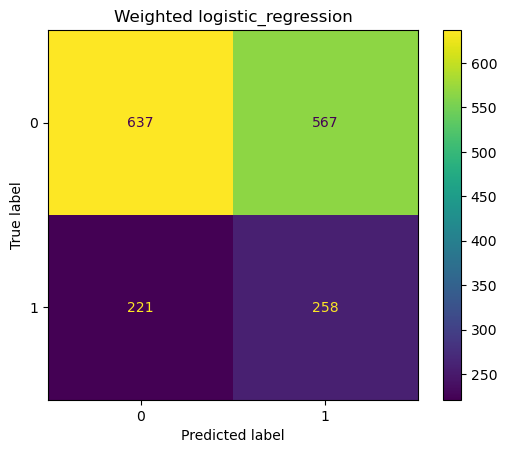

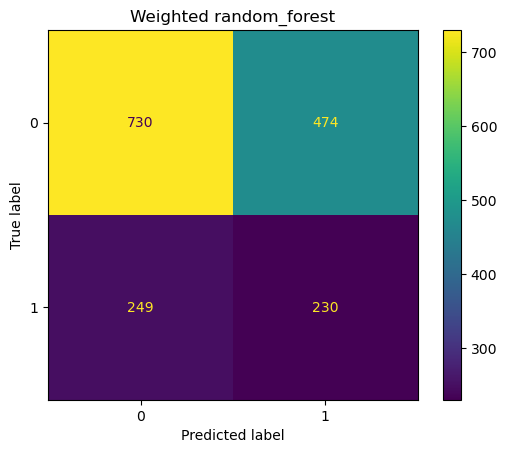

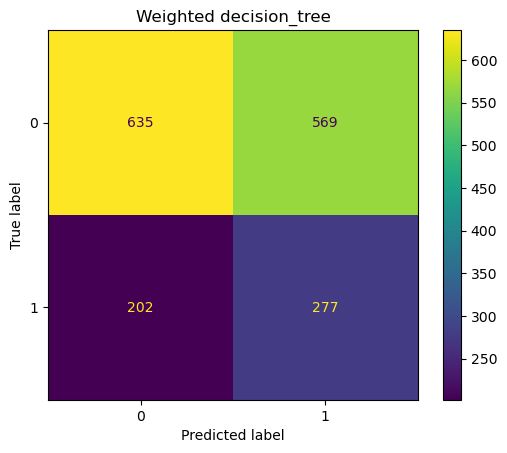

In [77]:
# Train and evaluate models on test set
# This is the final check

for (key, model) in models.items():
    print('MODEL:', key)
    model.fit(X_train, y_train)
    pred = model.predict(X_test)

    print('Accuracy:', accuracy_score(y_test, pred))
    print('Precision:', precision_score(y_test, pred))
    print('Recall:', recall_score(y_test, pred))
    print('f1-score:', f1_score(y_test, pred))
    print('AUC ROC:', roc_auc_score(y_test, model.predict_proba(X_test)[:,1]))
    print()
    print(classification_report(y_test, pred))
    print()
    ConfusionMatrixDisplay(confusion_matrix(y_test, pred)).plot()
    plt.title(f'Weighted {key}')

In [10]:
cm = confusion_matrix(y_test, (models['logistic_regression'].predict_proba(X_test)[:,1]) >= 0.514)
print(cm)
print("Confusion Matrix for a cutoff of", 0.514)
print('Precision:', cm[1][1]/(cm[1][1]+cm[0][1]))
print('Recall:', cm[1][1]/(cm[1][1]+cm[1][0]))

[[716 488]
 [244 235]]
Confusion Matrix for a cutoff of 0.514
Precision: 0.32503457814661135
Recall: 0.4906054279749478


In [11]:
cm = confusion_matrix(y_test, (models['logistic_regression'].predict_proba(X_test)[:,1]) >= 0.5)
print(cm)
print("Confusion Matrix for a cutoff of", 0.5)
print('Precision:', cm[1][1]/(cm[1][1]+cm[0][1]))
print('Recall:', cm[1][1]/(cm[1][1]+cm[1][0]))

[[637 567]
 [221 258]]
Confusion Matrix for a cutoff of 0.5
Precision: 0.31272727272727274
Recall: 0.5386221294363257


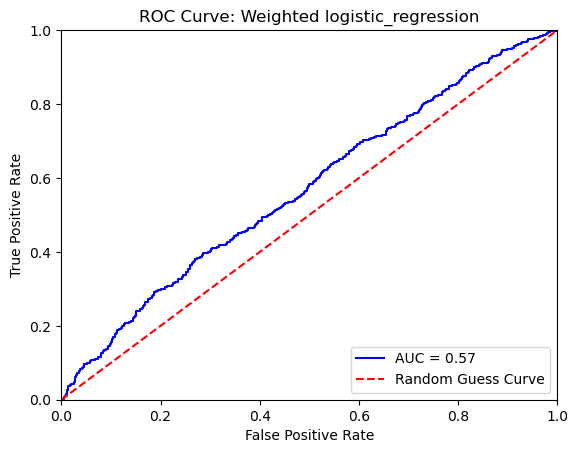

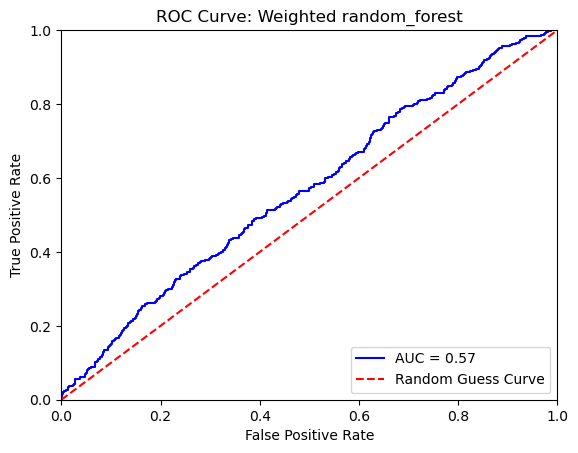

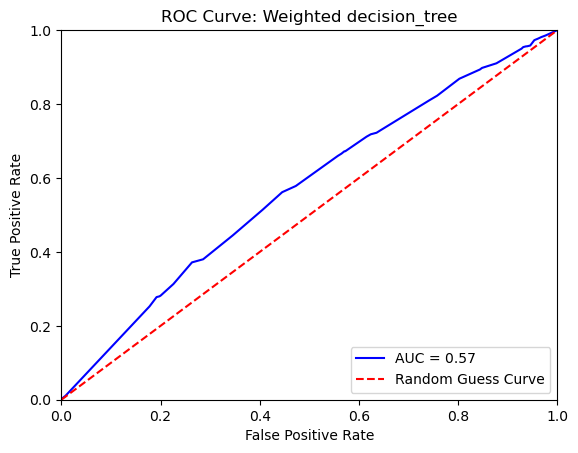

In [12]:
# plot ROC curve of each model

for (key, model) in models.items():
    fpr, tpr, thresholds = roc_curve(y_test, model.predict_proba(X_test)[:,1])
    roc_auc = auc(fpr,tpr)

    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
    plt.plot([0, 1], [0, 1],'r--', label="Random Guess Curve")
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.legend(loc = 'lower right')
    plt.title(f'ROC Curve: Weighted {key}')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.show()

In [13]:
# Find optimal threshold of predicted probabilities

for (key, model) in models.items():
    fpr, tpr, thresholds = roc_curve(y_test, model.predict_proba(X_test)[:,1])
    # Distance of point on roc curve closest to top left-hand corner
    distances = np.sqrt(fpr**2 + (1 - tpr)**2)
    optimal_idx = np.argmin(distances)
    optimal_threshold = thresholds[optimal_idx]
    print(f'Optimal threshold ({key}):', optimal_threshold)

Optimal threshold (logistic_regression): 0.5137742269548133
Optimal threshold (random_forest): 0.496604002564492
Optimal threshold (decision_tree): 0.5209429958949666


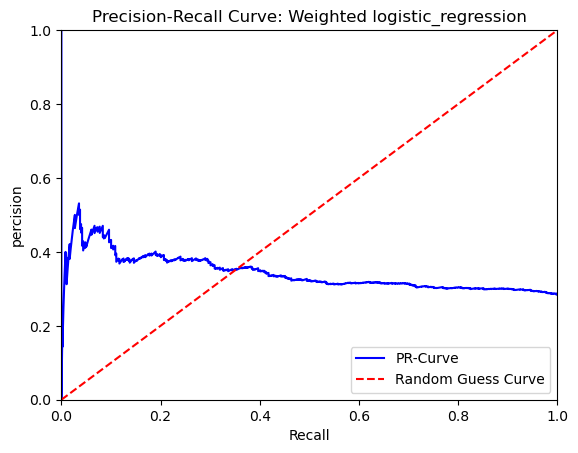

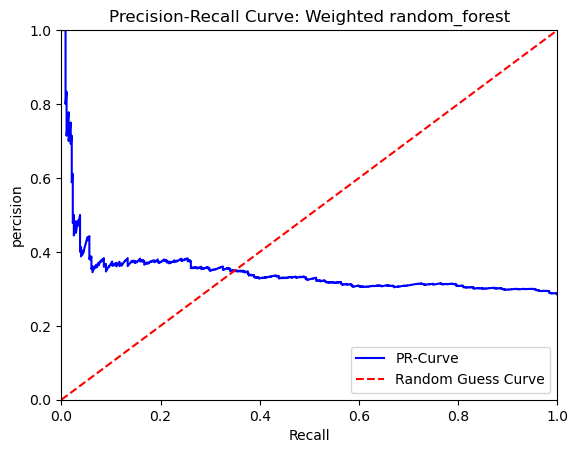

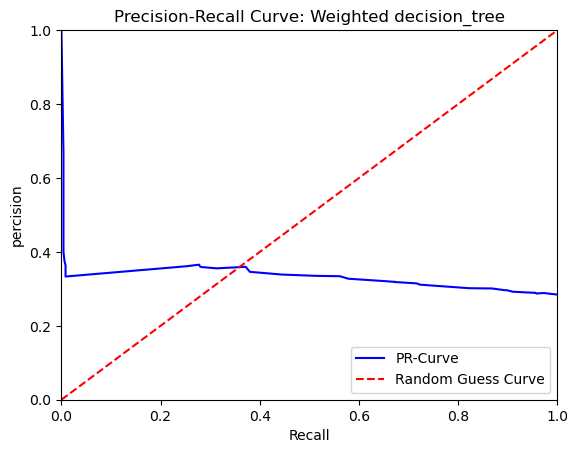

In [14]:
# plot precision-recall curve of each model

for (key, model) in models.items():
    precisions, recalls, thresholds = precision_recall_curve(y_test, model.predict_proba(X_test)[:,1])

    plt.plot(recalls, precisions, 'b', label='PR-Curve')
    plt.plot([0,1], [0,1], '--r', label='Random Guess Curve')
    plt.xlim([0,1])
    plt.ylim([0,1])
    plt.legend(loc = 'lower right')
    plt.title(f'Precision-Recall Curve: Weighted {key}')
    plt.xlabel('Recall')
    plt.ylabel('percision')
    plt.show()

## Check Overfitting

In [15]:
# for cross-validation (stratified kfold for imbalance)
kfold = StratifiedKFold(5,
              shuffle = True,
              random_state = 582)

# cv scores
for (key, model) in models.items():
    cv_scores = cross_val_score(model, X, y, cv=kfold)
    print(f"Cross-validation scores for {key}: {cv_scores}")
    # print(f"Mean cross-validation score for {key}: {cv_scores.mean()}")

Cross-validation scores for logistic_regression: [0.55080214 0.55199049 0.5620915  0.56599287 0.5665874 ]
Cross-validation scores for random_forest: [0.5674391  0.55496138 0.58407605 0.60463734 0.58739596]
Cross-validation scores for decision_tree: [0.52049911 0.55258467 0.53832442 0.52497027 0.57491082]


## Check Overfitting with Learning Curves

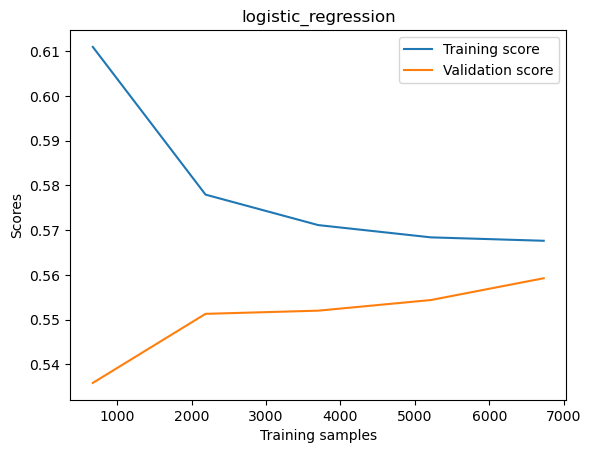

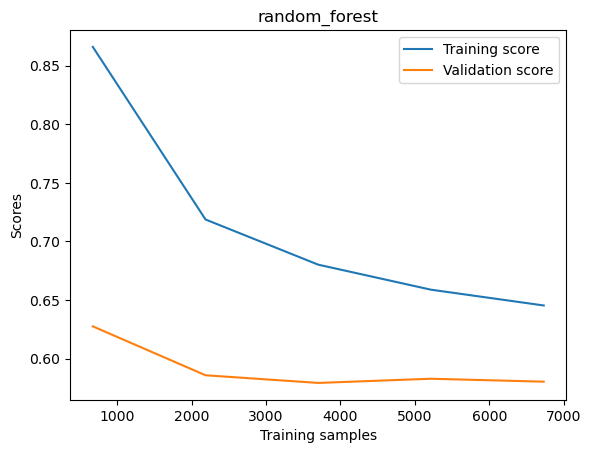

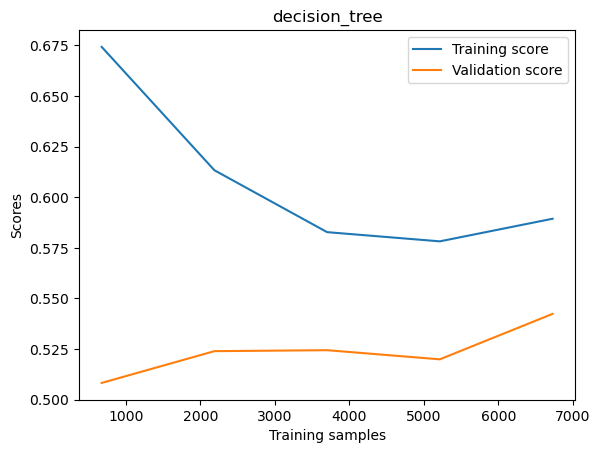

In [16]:
from sklearn.model_selection import learning_curve

for (key, model) in models.items():
    train_sizes, train_scores, test_scores = learning_curve(model, X, y, cv=kfold)
    plt.plot(train_sizes, train_scores.mean(axis=1), label='Training score')
    plt.plot(train_sizes, test_scores.mean(axis=1), label='Validation score')
    plt.legend()
    plt.xlabel('Training samples')
    plt.ylabel('Scores')
    plt.title(key)
    plt.show()

# Evaluation Metrics

### (Binary) Classification Evaluation Metrics

The best metrics to use for models trained on imbalanced data are `precision`, `recall`, and `F1-score`. The `accuracy` metric may not be the best indicator of performance, since it will always favor the majority class.

$$
\text{accuracy} = \frac{\text{TP+TN}}{\text{TP} + \text{TP+TN+FP+FN}},
$$

$$
\text{precision} = \frac{\text{TP}}{\text{TP} + \text{FP}},
$$

$$
\text{recall} = \frac{\text{TP}}{\text{TP} + \text{FN}}.
$$


The **$F_1$-score** is defined to be

$$F_1 = \frac{2}{\text{precision}^{-1} + \text{recall}^{-1}}$$

which is the harmonic mean of precision and recall. It is used as a performance metric for classification, and great for unbalanced data, hence is better than accuracy in these scenarios. 

- Excellent: $\quad F_1>0.9$ 
- Good: $\quad 0.8 \le F_1\le 0.9$ 
- Average: $\quad 0.5 \le F_1\le 0.8$ 
- Poor: $\quad F_1<0.5$ 

Excellent performance scores for `precision` and `recall` are greater than `%80`, while poor scores are less than `%50`, which is worst than random guessing.

## Adjusting the Probability Threshold

In [17]:
# Precision and recall scores for different threshold cutoffs (for positive class)
# threshold = 0.5 (default) is the same as above
for i in range(1,9):
    cm = confusion_matrix(y_test, (models['logistic_regression'].predict_proba(X_test)[:,1]) >= i/10)
    print(cm)
    print("Confusion Matrix for a cutoff of", i/10)
    print('Precision:', cm[1][1]/(cm[1][1]+cm[0][1]))
    print('Recall:', cm[1][1]/(cm[1][1]+cm[1][0]))
    print()

[[   0 1204]
 [   0  479]]
Confusion Matrix for a cutoff of 0.1
Precision: 0.2846108140225787
Recall: 1.0

[[   0 1204]
 [   1  478]]
Confusion Matrix for a cutoff of 0.2
Precision: 0.28418549346016647
Recall: 0.9979123173277662

[[  29 1175]
 [   6  473]]
Confusion Matrix for a cutoff of 0.3
Precision: 0.28701456310679613
Recall: 0.9874739039665971

[[229 975]
 [ 60 419]]
Confusion Matrix for a cutoff of 0.4
Precision: 0.3005738880918221
Recall: 0.8747390396659708

[[637 567]
 [221 258]]
Confusion Matrix for a cutoff of 0.5
Precision: 0.31272727272727274
Recall: 0.5386221294363257

[[1056  148]
 [ 384   95]]
Confusion Matrix for a cutoff of 0.6
Precision: 0.39094650205761317
Recall: 0.19832985386221294

[[1195    9]
 [ 474    5]]
Confusion Matrix for a cutoff of 0.7
Precision: 0.35714285714285715
Recall: 0.010438413361169102

[[1204    0]
 [ 479    0]]
Confusion Matrix for a cutoff of 0.8
Precision: nan
Recall: 0.0



/var/folders/3q/y9742sx165z4bv135ly3_55c0000gn/T/ipykernel_1184/777050100.py:7: RuntimeWarning: invalid value encountered in scalar divide
  print('Precision:', cm[1][1]/(cm[1][1]+cm[0][1]))


In [18]:
# This maximizes Youden's J statistic
print('Optimal threshold:', thresholds[np.argmax(tpr-fpr)])

Optimal threshold: 0.4073905059121845


In [19]:
# Distance of point on roc curve closest to top left-hand corner
distances = np.sqrt(fpr**2 + (1 - tpr)**2)
optimal_idx = np.argmin(distances)
optimal_threshold = thresholds[optimal_idx]
print('Optimal threshold:', optimal_threshold)

Optimal threshold: 0.4073905059121845


## GridSearch Logistic Regression

In [20]:
# class weights
w = [{0:30, 1:15}, {0:90, 1:10}, {0:80, 1:25}, {0:90, 1:50}, {0:200, 1:100}]

grid_cv = GridSearchCV(LogisticRegression(), 
                   param_grid = {"class_weight": w,
                                 'max_iter': [1000]},
                   scoring = 'recall',
                   cv = 5,
                   refit = True)

grid_cv.fit(X_train, y_train)

print(f'Best score: {grid_cv.best_score_} with param: {grid_cv.best_params_}')

Best score: 0.0 with param: {'class_weight': {0: 30, 1: 15}, 'max_iter': 1000}


                    precision    recall  f1-score   support

 Ambulance: No = 1       0.72      1.00      0.83      1204
Ambulance: Yes = 0       0.00      0.00      0.00       479

          accuracy                           0.72      1683
         macro avg       0.36      0.50      0.42      1683
      weighted avg       0.51      0.72      0.60      1683


The AUC ROC is 0.61078644919358
Test accuracy: 0.7153891859774213
Training accuracy: 0.7151560178306092
Cross-validation scores: [0.71538919 0.71538919 0.71479501 0.71521998 0.71521998]
Mean cross-validation score: 0.7152026666610146


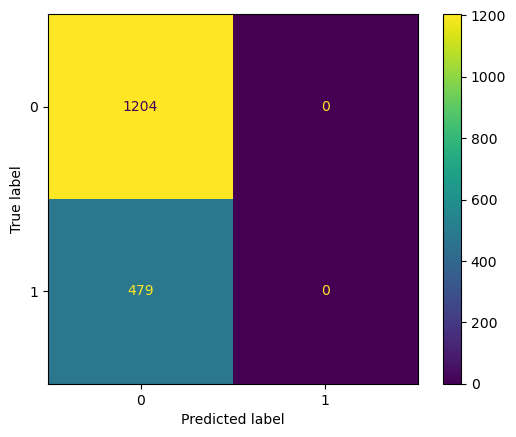

In [21]:
# logistic regression model with optimal hyperparameters 
lg3 = grid_cv.best_estimator_

y_pred_3 = lg3.predict(X_test)

# performance evaluation
print(classification_report(y_test, y_pred_3, zero_division=0.0,
                            target_names = ['Ambulance: No = 1', 'Ambulance: Yes = 0']))
print()
print("The AUC ROC is", roc_auc_score(y_train, lg3.predict_proba(X_train)[:,1]))
print(f"Test accuracy:", accuracy_score(y_test, lg3.predict(X_test)))
print(f"Training accuracy:", accuracy_score(y_train, lg3.predict(X_train)))

# cv scores
cv_scores = cross_val_score(lg3, X, y, cv=kfold)
print(f"Cross-validation scores: {cv_scores}")
print(f"Mean cross-validation score: {cv_scores.mean()}")

# plot confusion matrix
ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred_3)).plot()

## Decision Trees

In [22]:
pd.DataFrame({'features' : X_train.columns,
              'importance_score' : models['decision_tree'].feature_importances_}).sort_values('importance_score', ascending=False)

,features,importance_score
1,CrashHour,0.171255
30,SpeedLimit_At most 35 MPH,0.138011
2,CrashMonth,0.095998
8,BikeRace_Black,0.090812
4,BikeAgeGrp_50 and above,0.083854
0,CrashDay,0.051002
31,TraffCntrl_No Control Present,0.049759
25,RdConfig_Not Divided,0.038465
14,CrashLoc_Intersection-Related,0.036319
22,RdCharacte_Straight - Level,0.032630


## Weighted Random Forest

In [23]:
# Pretty much the same as the unweighted random forest
pd.DataFrame({'feature' : X_train.columns,
              'importance_score' : models['random_forest'].feature_importances_}).sort_values('importance_score', ascending=False)

,feature,importance_score
1,CrashHour,0.104553
30,SpeedLimit_At most 35 MPH,0.082928
2,CrashMonth,0.081418
0,CrashDay,0.064109
4,BikeAgeGrp_50 and above,0.058968
8,BikeRace_Black,0.045338
12,BikeRace_White,0.044863
18,LightCond_Daylight,0.041032
20,Locality_Urban (>70% Developed),0.036105
23,RdClass_Not Local Street,0.032446


### Hyperparameter Tuning


The code below randomly searches for the best hyperparameters, in a given range for each hyperparameter, for the random forest model.

In [24]:
# # The chosen hyperparameters for the random forest model, and their given ranges, stored in a dictionary 
# param_dist = {'n_estimators': randint(50,500),
#               'max_depth': randint(1,20)}

# rf = RandomForestClassifier()

# # Use random search to find the best hyperparameters
# rand_search = RandomizedSearchCV(rf, 
#                                  param_distributions = param_dist, 
#                                  n_iter=5, 
#                                  cv=5)

# rand_search.fit(X_train, y_train)

# # This takes a while to run
# print('Best hyperparameters:',  rand_search.best_params_)

# Multi Classification

We train our models with a multi categorical target the 'BikeInjury' column.

In [25]:
## The selected features (X)
features = ['CrashDay', 'CrashMonth', 'CrashHour', 'NumLanes', 'RdCharacte', 'RdConditio', 'RdFeature', 'Region', 'TraffCntrl', 'Weather']

## The same features 
X_multi = pd.get_dummies(bicycle[features], 
                   dtype=int, 
                   drop_first=True)

## Multi-categorical target (no need to encode)
y_multi = bicycle['BikeInjury']

## Split data into training and testing sets
X_multi_train, X_multi_test, y_multi_train, y_multi_test = train_test_split(X_multi, y_multi, 
                                                    test_size=0.2, 
                                                    random_state=512,
                                                    shuffle=True)

## Multinomial Logistic Regression

In [26]:
## Weighted multinomial Logistic Regression model

multilog_reg = LogisticRegression(penalty=None, max_iter=1000, class_weight='balanced')

multilog_reg.fit(X_multi_train, y_multi_train)

## Evaluate on training and testing sets
train_multilog_pred = multilog_reg.predict(X_multi_train)
test_multilog_pred = multilog_reg.predict(X_multi_test)

In [27]:
print(f"Test accuracy:", accuracy_score(y_multi_test, test_multilog_pred))
print(f"Training accuracy:", accuracy_score(y_multi_train, train_multilog_pred))

Test accuracy: 0.1948900772430184
Training accuracy: 0.2050520059435364


In [28]:
cv_scores = cross_val_score(multilog_reg, X_multi, y_multi, cv=5)
print(f"Cross-validation scores: {cv_scores}")
print(f"Mean cross-validation score: {cv_scores.mean()}")

Cross-validation scores: [0.20796197 0.19786096 0.21212121 0.18727705 0.17538644]
Mean cross-validation score: 0.19612152863883997


It appears that the multinomial logistic regression model performs less accurate than the binomial logistic regression model.

In [29]:
i = 0
for cat in multilog_reg.classes_:
    print(f"Mean of predicted probabilities of class '{cat}':", multilog_reg.predict_proba(X_multi_train)[:,i].mean())
    i =+ 1

Mean of predicted probabilities of class 'A: Suspected Serious Injury': 0.1976416938270337
Mean of predicted probabilities of class 'B: Suspected Minor Injury': 0.20313687997563792
Mean of predicted probabilities of class 'C: Possible Injury': 0.20313687997563792
Mean of predicted probabilities of class 'K: Killed': 0.20313687997563792
Mean of predicted probabilities of class 'O: No Injury': 0.20313687997563792


In [30]:
# Evaluation metrics for multi classification
print(classification_report(y_multi_test, test_multilog_pred, zero_division=0.0))

                             precision    recall  f1-score   support

A: Suspected Serious Injury       0.07      0.29      0.12        97
  B: Suspected Minor Injury       0.46      0.08      0.14       738
         C: Possible Injury       0.44      0.27      0.33       657
                  K: Killed       0.05      0.50      0.09        38
               O: No Injury       0.11      0.29      0.16       153

                   accuracy                           0.19      1683
                  macro avg       0.23      0.29      0.17      1683
               weighted avg       0.39      0.19      0.22      1683



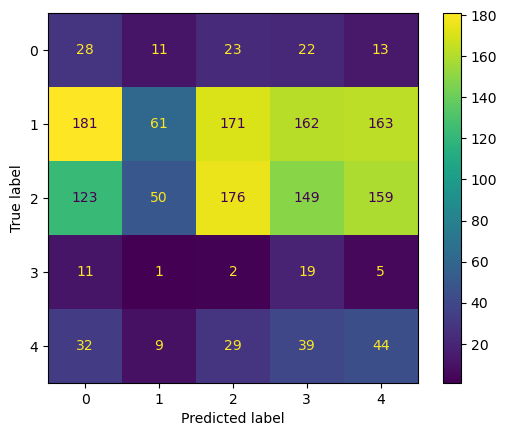

In [31]:
# Confusion matrix of weighted multilogistic regression 
cm = confusion_matrix(y_multi_test, test_multilog_pred)

ConfusionMatrixDisplay(confusion_matrix=cm).plot()

# Downsampling and Upsampling

In [32]:
from imblearn.over_sampling import SMOTE

In [33]:
# Always downsample/upsample AFTER a train-test-split
# Upsampling the training sets
sm = SMOTE(random_state=42)
X_res, y_res = sm.fit_resample(X_train, y_train)

In [34]:
print(X.shape, y.shape)
print(X_res.shape, y_res.shape)

(8413, 34) (8413,)
(9626, 34) (9626,)


                    precision    recall  f1-score   support

 Ambulance: No = 1       0.73      0.71      0.72      1204
Ambulance: Yes = 0       0.31      0.33      0.32       479

          accuracy                           0.60      1683
         macro avg       0.52      0.52      0.52      1683
      weighted avg       0.61      0.60      0.61      1683



Text(0.5, 1.0, 'Logistic Regression (SMOTE)')

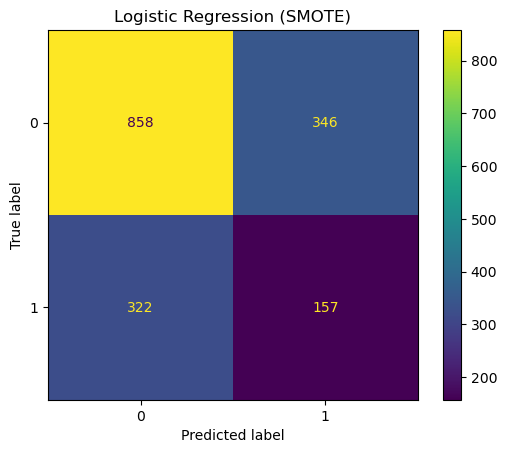

In [35]:
# Train logistic regression on upsamled data
lr_smote = LogisticRegression(penalty=None, max_iter=1000)

lr_smote.fit(X_res, y_res)

print(classification_report(y_test, lr_smote.predict(X_test), zero_division=0.0,
                            target_names = ['Ambulance: No = 1', 'Ambulance: Yes = 0']))

ConfusionMatrixDisplay(confusion_matrix(y_test, lr_smote.predict(X_test))).plot()
plt.title('Logistic Regression (SMOTE)')

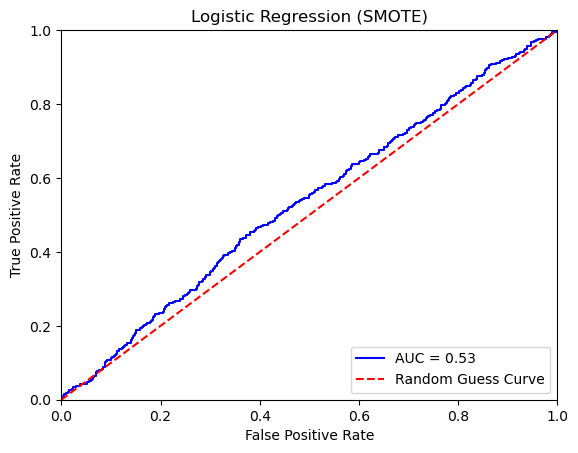

In [36]:
fpr, tpr, thresholds = roc_curve(y_test, lr_smote.predict_proba(X_test)[:,1])
roc_auc = auc(fpr,tpr)

plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.plot([0, 1], [0, 1],'r--', label="Random Guess Curve")
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.legend(loc = 'lower right')
plt.title('Logistic Regression (SMOTE)')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.show()

This is a bad ROC curve. The predictions are worse than random guessing.

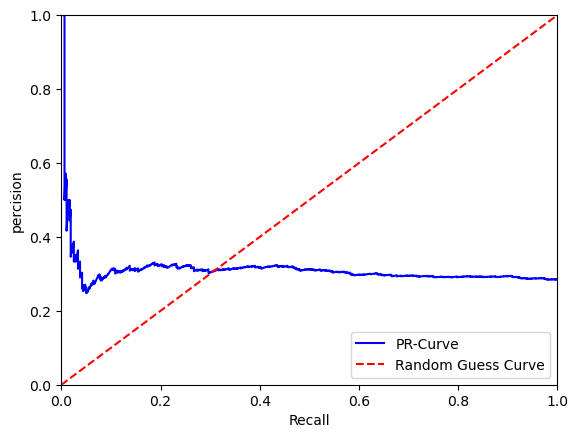

In [37]:
precisions, recalls, thresholds = precision_recall_curve(y_test, lr_smote.predict_proba(X_test)[:,1])

plt.plot(recalls, precisions, 'b', label='PR-Curve')
plt.plot([0,1], [0,1], '--r', label='Random Guess Curve')
plt.xlim([0,1])
plt.ylim([0,1])
plt.legend(loc = 'lower right')
plt.xlabel('Recall')
plt.ylabel('percision')
plt.show()

                    precision    recall  f1-score   support

 Ambulance: No = 1       0.73      0.57      0.64      1204
Ambulance: Yes = 0       0.31      0.48      0.37       479

          accuracy                           0.55      1683
         macro avg       0.52      0.52      0.51      1683
      weighted avg       0.61      0.55      0.57      1683



Text(0.5, 1.0, 'Random Forest (SMOTE)')

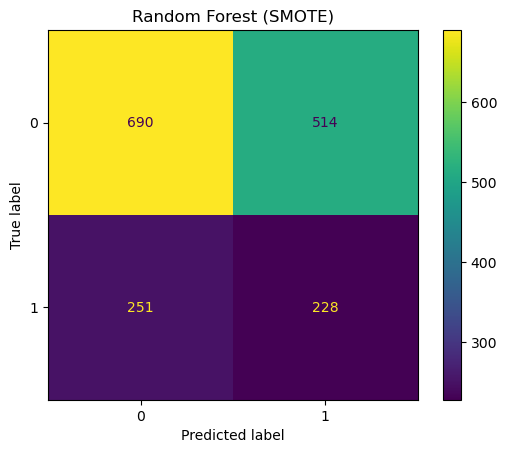

In [38]:
forest_smote = RandomForestClassifier(n_estimators=1000, max_depth=3)

forest_smote.fit(X_res, y_res)

print(classification_report(y_test, forest_smote.predict(X_test), zero_division=0.0,
                            target_names = ['Ambulance: No = 1', 'Ambulance: Yes = 0']))

ConfusionMatrixDisplay(confusion_matrix(y_test, forest_smote.predict(X_test))).plot()
plt.title('Random Forest (SMOTE)')

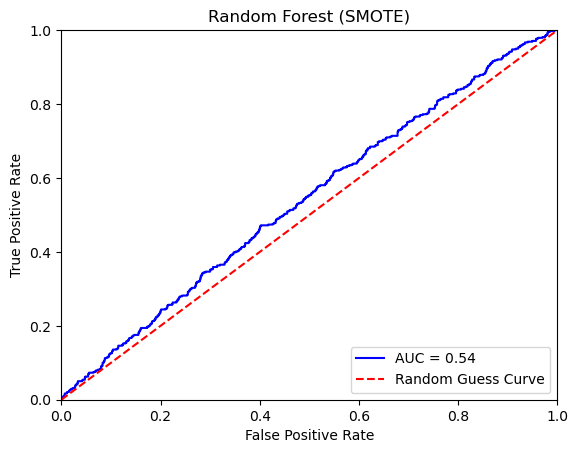

In [39]:
fpr, tpr, thresholds = roc_curve(y_test, forest_smote.predict_proba(X_test)[:,1])
roc_auc = auc(fpr,tpr)

plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.plot([0, 1], [0, 1],'r--', label="Random Guess Curve")
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.legend(loc = 'lower right')
plt.title('Random Forest (SMOTE)')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.show()

# Target: Severity

In this section, our target $y$ is the `Severity` feature.

In [40]:
bicycle['Severity'].value_counts(normalize=True)

Severity
0    0.917746
1    0.082254
Name: proportion, dtype: float64

In [41]:
features = bicycle.columns.drop(['AmbulanceR','BikeInjury','Severity'])

# Features
X = pd.get_dummies(bicycle[features], 
                   dtype=int, 
                   drop_first=True)
# Target
y = bicycle['Severity']

X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size = 0.2, 
                                                    random_state = 42,
                                                    shuffle = True,
                                                    stratify = y)

In [42]:
models = {'logistic_regression' : LogisticRegression(penalty=None, max_iter=1000, class_weight='balanced'),
          'random_forest' : RandomForestClassifier(n_estimators=500, max_depth=4, class_weight='balanced'),
          'decision_tree' : DecisionTreeClassifier(max_depth=4, random_state= 216, class_weight='balanced')}

Model: logistic_regression

              precision    recall  f1-score   support

           0       0.96      0.68      0.80      1545
           1       0.16      0.70      0.27       138

    accuracy                           0.69      1683
   macro avg       0.56      0.69      0.53      1683
weighted avg       0.90      0.69      0.76      1683

Model: random_forest

              precision    recall  f1-score   support

           0       0.95      0.75      0.84      1545
           1       0.18      0.60      0.28       138

    accuracy                           0.74      1683
   macro avg       0.57      0.68      0.56      1683
weighted avg       0.89      0.74      0.80      1683

Model: decision_tree

              precision    recall  f1-score   support

           0       0.96      0.58      0.72      1545
           1       0.13      0.74      0.23       138

    accuracy                           0.59      1683
   macro avg       0.55      0.66      0.47      1683
we

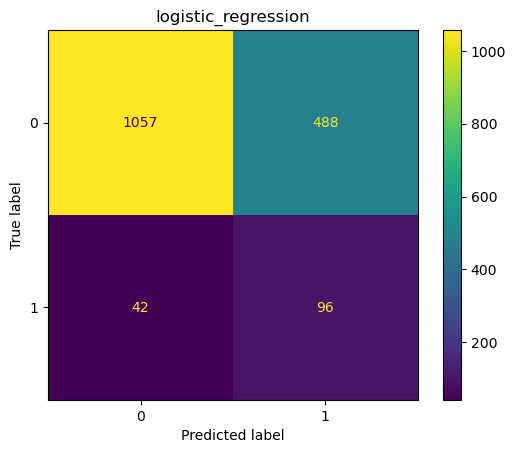

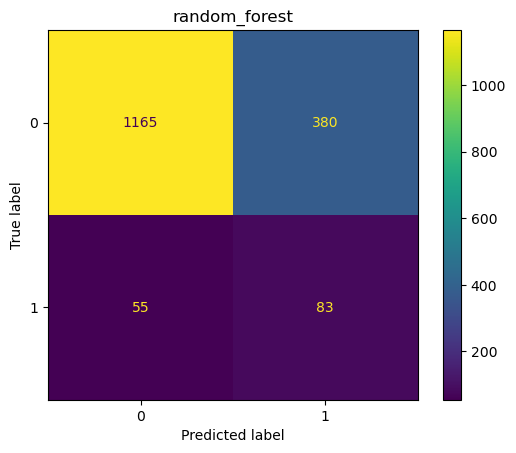

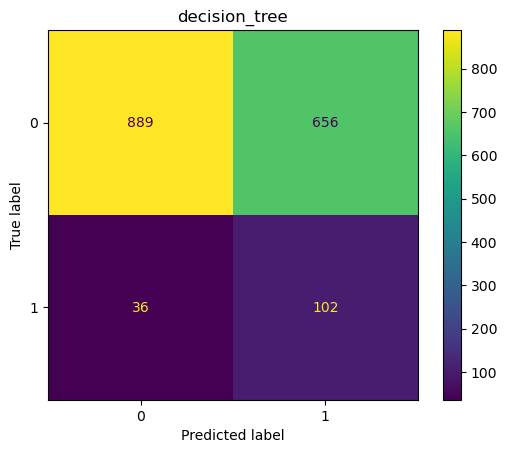

In [43]:
for (key, model) in models.items():
    print('Model:', key)
    print()
    model.fit(X_train, y_train)
    pred = model.predict(X_test)
    print(classification_report(y_test, pred))
    ConfusionMatrixDisplay(confusion_matrix(y_test, pred)).plot()
    plt.title(key)